In [1]:
from copy import copy

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.Calibration.SCF.WealthIncomeDist.SCFDistTools import (
    income_wealth_dists_from_scf,
)
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    init_lifecycle,
)
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
Agent = IndShockConsumerType(**params)
Agent.solve()

Consumption functions


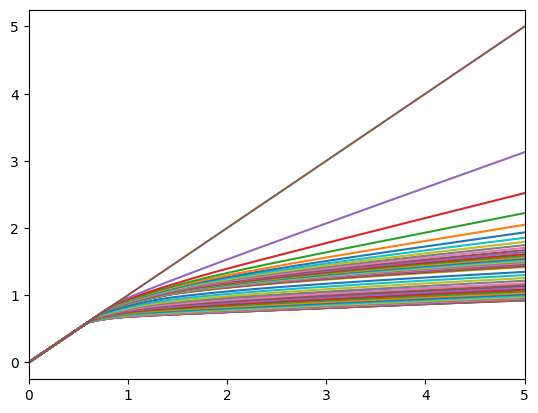

In [4]:
Agent.unpack("cFunc")
# Plot the consumption functions
print("Consumption functions")
plot_funcs(Agent.cFunc, 0, 5)

In [5]:
# Number of agents and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[ 0.31364439,  0.68328755,  0.33216606, ...,  1.46260686,
          3.4195494 ,  0.21984699],
        [ 0.11248137,  0.53046953,  1.15777054, ...,  1.16308543,
          3.04617131,  1.08561761],
        [ 0.08764637,  0.767089  ,  1.149847  , ...,  0.46648523,
          2.08618626,  0.93244693],
        ...,
        [ 1.96867774, 45.87318776,  5.52962025, ...,  5.19152543,
          2.85362794,  4.65126659],
        [ 2.07342744, 42.61183927,  6.29429272, ...,  4.72409643,
          2.46507888,  5.31266765],
        [ 2.20199511, 39.36367199,  5.25115167, ...,  5.29590556,
          2.79144426,  5.74426791]]),
 'cNrm': array([[0.85099957, 0.92358996, 0.85625338, ..., 1.00082342, 1.13782156,
         0.81734291],
        [0.75655825, 0.88833506, 0.9595059 , ..., 0.95997564, 1.09306043,
         0.953129  ],
        [0.73798245, 0.91223536, 0.94815242, ..., 0.87032859, 1.01569239,
         0.92915141],
        ...,
        [1.00775503, 5.78035487, 1.02374688, ..., 1.0958

In [6]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

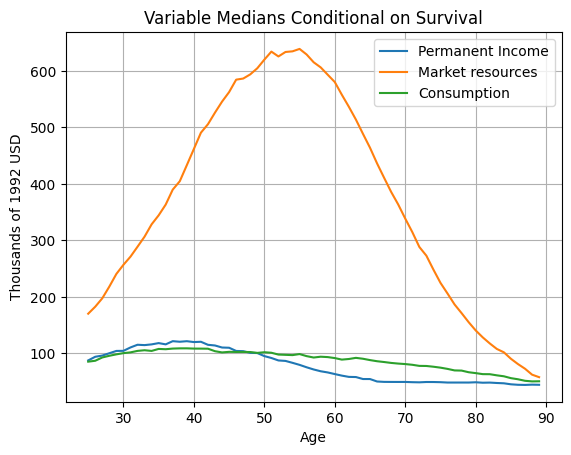

In [7]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()